In [ ]:
%pip install boto3 nibabel numpy matplotlib

Fetching file: BraTS20_Training_369_flair.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpcxrxiiwr.nii
Data shape for BraTS20_Training_369_flair.nii: (240, 240, 155)
Saving in directory: brain_slices/369/flair/


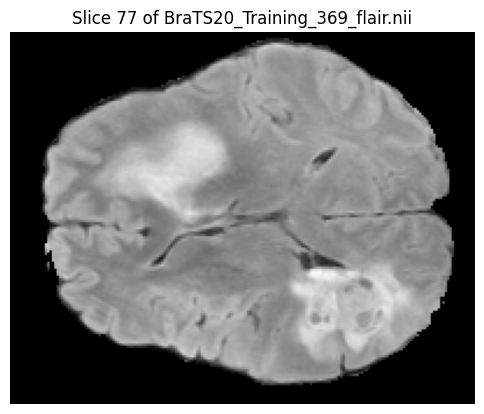

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpcxrxiiwr.nii
Fetching file: BraTS20_Training_369_seg.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmplon1trnm.nii
Data shape for BraTS20_Training_369_seg.nii: (240, 240, 155)
Saving in directory: brain_slices/369/seg/


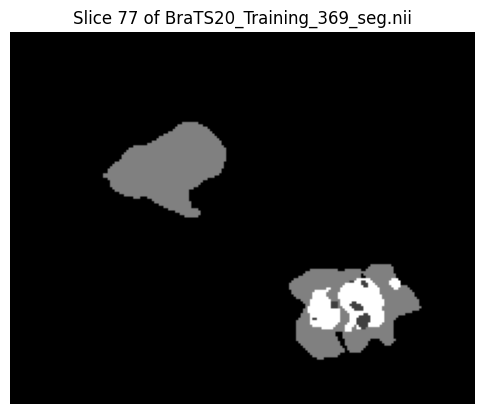

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmplon1trnm.nii
Fetching file: BraTS20_Training_369_t1.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpxm9uig8c.nii
Data shape for BraTS20_Training_369_t1.nii: (240, 240, 155)
Saving in directory: brain_slices/369/t1/


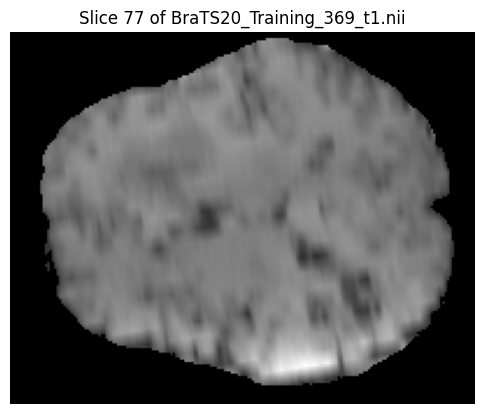

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpxm9uig8c.nii
Fetching file: BraTS20_Training_369_t1ce.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpyka96juz.nii
Data shape for BraTS20_Training_369_t1ce.nii: (240, 240, 155)
Saving in directory: brain_slices/369/t1ce/


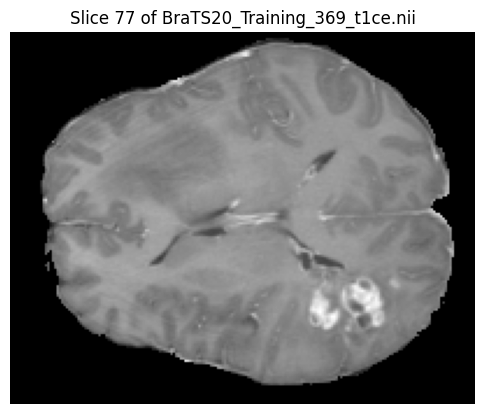

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpyka96juz.nii
Fetching file: BraTS20_Training_369_t2.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpntdzsvac.nii
Data shape for BraTS20_Training_369_t2.nii: (240, 240, 155)
Saving in directory: brain_slices/369/t2/


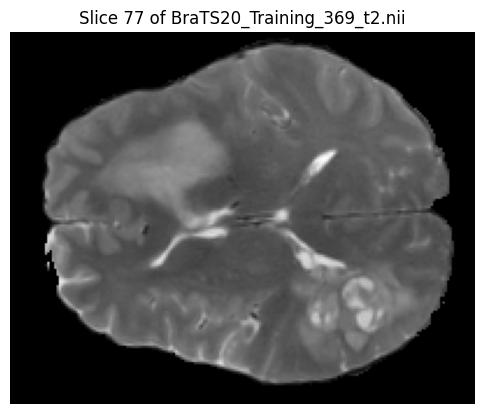

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpntdzsvac.nii


In [49]:
import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import tempfile
import os

# Initialize S3 resource and specify bucket and folder details
s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'Data/BraTS20_Training_369 copy/'
bucket = s3.Bucket(bucket_name)

def plot_slice(data, crop, slice_idx):
    # Crop the specified slice
    slice_2d = data[:, :, slice_idx]
    cropped_slice = slice_2d[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    
    # Display the cropped slice with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_slice, cmap='gray')
    plt.title(f'Slice {slice_idx} of {filename}')
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

def savePNG(data, crop):    
    # Prepare directory structure
    fileWOext = filename.split(".")[0]
    TrainingCount = fileWOext.split("_")[-2]
    ScanType = fileWOext.split("_")[-1]
    slice_path = f"brain_slices/{TrainingCount}/{ScanType}/"
    print(f"Saving in directory: {slice_path}")

    # Iterate through each slice in the Z-Dimiension data and save as PNG
    for slice_idx in range(data.shape[2]):
        # Crop each slice
        slice_2d = data[:, :, slice_idx]
        cropped_slice = slice_2d[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
        try:
            # Create directories as needed and save each slice
            os.makedirs(slice_path, exist_ok=True)
            mpimg.imsave(f"{slice_path}/{slice_idx}.png", cropped_slice, cmap='gray')
        except Exception as e:
            print(f"ERROR: directory could not be made due to {e}")

def render_nii_from_s3(filename):
    print(f"Fetching file: {filename}")

    obj = bucket.Object(folder_path + filename)
    file_stream = io.BytesIO(obj.get()['Body'].read())

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:  # Prevent auto-deletion
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name
        print(f"Temporary file created: {temp_file_path}")

    try:
        img = nib.load(temp_file_path)
        data = img.get_fdata()

        print(f"Data shape for {filename}: {data.shape}")
        
        if data.size == 0:
            print(f"No data found in {filename}")
            return

        # Define crop dimensions
        cropleft = 25
        cropright = data.shape[0] - 15
        cropbottom = data.shape[1] - 40
        croptop = 40        
        crop = np.array([[croptop, cropbottom], [cropleft, cropright]])
        
        # Save the PNGs and plot a sample slice
        savePNG(data, crop)
        slice_idx = 77  # Choose a slice index for sample display
        plot_slice(data, crop, slice_idx)

    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        
    finally:
        try:
            os.remove(temp_file_path)
            print(f"Deleted temporary file: {temp_file_path}")
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

found_files = False
for obj in bucket.objects.filter(Prefix=folder_path):
    if obj.key.endswith('.nii'):
        found_files = True
        filename = obj.key.split('/')[-1]  # Extract filename from path
        render_nii_from_s3(filename)

if not found_files:
    print(f"No .nii files found in the folder {folder_path}")

## Function Documentation

### `render_nii_from_s3`

1. **Approach:** I set up `render_nii_from_s3` to fetch `.nii` files from S3, load them as temporary files, and process them with `nibabel`. Using a temporary file was essential because `nibabel` requires file-based data.

2. **Challenges and Solutions:**
   - **Cropping Dimensions:** Determining the right crop dimensions took small amounts of trial and error, especially with files of varying shapes. I experimented with different parameters to get a consistent crop size that centers on relevant areas of each slice.
   - **Iterating Through the Z-Dimension:** Initially, handling each 2D slice in a 3D volume was tricky. By iterating over the z-dimension, I was able to handle the depth of each scan and ensure each slice was processed individually.
   - **Image Storage:** Storing the images as PNGs had some issues for where i wanted to store them. Also, i had initally though the PNG slices were faulty when i saw some images were pure black 
   - **Consolidating Functions:** I then decided to break up code into smaller functions like `plot_slice` and `savePNG` to help with code readibility

3. **Conclusion:** This function now smoothly integrates file retrieval, temporary storage, cropping, and saves each slice individually through calls to `savePNG` and `plot_slice`.

### `plot_slice`

1. **Approach:** To verify the image cropping, this function crops and plots a specific MRI slice using `matplotlib`.

2. **Challenges and Solutions:** (Technically none since it was started code)

3. **Conclusion:** This function allows for viewing of slices and ensures that data preprocessing steps are correctly applied.

### `savePNG`

1. **Approach:** This function saves each MRI slice as a PNG image, organized in directories by `TrainingCount` and `ScanType` parsed from `filename`.

2. **Challenges and Solutions:**
   - **Path Setup:** Managing paths for each slice required consolidating the directory creation, so I used `os.makedirs(slice_path, exist_ok=True)` (may not work for MacOS, who knows!).
   - **Error Handling:** A try-except block helps address potential file system issues during directory creation or saving, ensuring that errors don’t halt processing.

3. **Conclusion:** `savePNG` iterates over each slice, applies cropping, and saves each image (if it doesnt already exist).

# You will not see the folders created since it is in .gitignore